In [492]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 6, 4
import warnings

warnings.filterwarnings("ignore")

## Task 1 (5+5+5+5+5=25 pts)

### Consider the dataset HW2_task1.csv, a binary classification problem with two real-valued input attributes.  As you can see from the plot, the dataset is linearly separable. Train a linear SVM (setting C=100000 just to emphasize that no slack variables are allowed) and  answer the following five questions: 

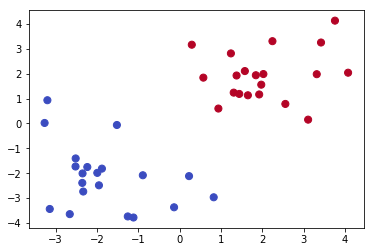

In [378]:
# Data
data1=pd.read_csv('HW2_task1.csv')
X=data1.iloc[:,:2]
Y=data1.iloc[:,2]
plt.gca()
plt.scatter(X.iloc[:,0], X.iloc[:,1], s=50, c=Y, cmap=plt.cm.get_cmap('coolwarm', 2))
plt.show()

In [379]:
data1.head(10)

,x1,x2,y
0,-2.515039,-1.408103,0
1,-1.952127,-2.488405,0
2,-2.354953,-2.391813,0
3,-0.135739,-3.371490,0
4,0.226275,-2.118110,0
5,-1.880152,-1.817401,0
6,-2.657739,-3.646232,0
7,-3.141584,-3.439089,0
8,-1.255008,-3.739220,0
9,-2.332197,-2.738413,0


#### a. Report the separating hyperplane (line).

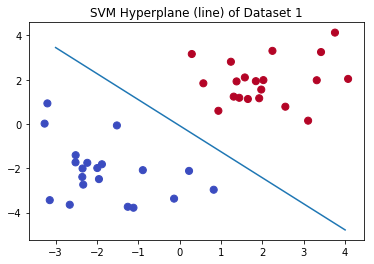

--- coefficient ---
[ 0.66329036  0.56359437]


In [380]:
# Train a SVM classifier

clf = svm.SVC(C = 10000, kernel='linear')
clf.fit(X, Y)

# Get the Hyperplane parameters
w = clf.coef_[0]
a = -w[0] / w[1]
x1 = np.linspace(-3, 4)
x2 = a * x1 - (clf.intercept_[0]) / w[1]

# Plot the Graph

plt.gca()
plt.scatter(X.iloc[:,0], X.iloc[:,1], s=50, c=Y, cmap=plt.cm.get_cmap('coolwarm', 2))
plt.plot(x1, x2)
plt.title("SVM Hyperplane (line) of Dataset 1");
plt.show()

print('--- coefficient ---')
print(w)

#### b. List the support vectors.

--- Support Vectors ---
[[ 0.22627536 -2.11810965]
 [-1.5180363  -0.06399383]
 [ 0.93564585  0.5969359 ]]


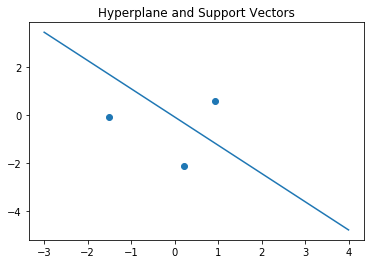

In [381]:
vectors = clf.support_vectors_
x = []
y = []
for v in vectors:
    x.append(v[0])
    y.append(v[1])
    
plt.scatter(x, y)
plt.plot(x1, x2)
plt.title("Hyperplane and Support Vectors");

print("--- Support Vectors ---")
print(vectors)

#### c. Calculate the upper and lower hyperplanes (lines) of the margin.

Lower Margin Line: y = -1.1768931608710185x + -1.851807718698718
Upper Margin Line: y = -1.1768931608710185x + 1.6980911044614855


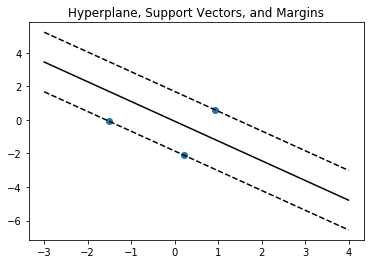

In [382]:
# Calculate the upper and lower margins
b = clf.support_vectors_[0]
x2_down = a * x1 + (b[1] - a * b[0])
print("Lower Margin Line: y = {}x + {}".format(a, b[1] - a * b[0]))

b = clf.support_vectors_[-1]
x2_up = a * x1 + (b[1] - a * b[0])
print("Upper Margin Line: y = {}x + {}".format(a, b[1] - a * b[0]))

# Plot Hyperplane, support vectors, and upper / lower margins
plt.scatter(x, y)
plt.plot(x1, x2, 'k-')
plt.plot(x1, x2_down, 'k--')
plt.plot(x1, x2_up, 'k--')
plt.title("Hyperplane, Support Vectors, and Margins");

#### d. Compute the width of the margin.

In [383]:
# Calculate M = 1 / distance of w 

M = 1 / np.sqrt(w[0]*w[0] + w[1]*w[1])
print("The width of the Margin: {}".format(M))

The width of the Margin: 1.1488996752138216


#### e. What would you expect to happen to the margin if the constant C was made very small?

This will increase the width of margin as C decreases.

## Task 2 (4+8+8=20 pts)

### Given the dataset provided below, answer the following two questions:

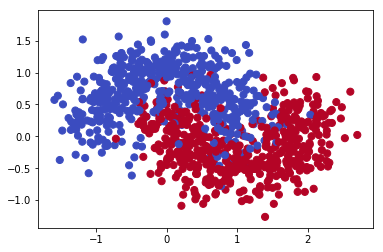

In [384]:
# Data 
data2=pd.read_csv('HW2_task2.csv')
X=data2.iloc[:,:2]
Y=data2.iloc[:,2]

plt.gca()
plt.scatter(X.iloc[:,0], X.iloc[:,1], s=50, c=Y, cmap=plt.cm.get_cmap('coolwarm', 2));
plt.show()

# Generate training (X_train, Y_train) and testing (X_test, Y_test) datasets 
#for out of sample test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=1)

### a. Train a polynomial SVM using the training set. Use the default arguments, and report both in-sample (training set) and out-of-sample (test set) classification accuracy.

In [385]:
# Train a polynomial SVM
clf = svm.SVC(kernel='rbf',gamma=1) 
clf.fit(X_train, Y_train)

# Measure In-Sample Score
pred = clf.predict(X_train)
print("In Sample Accuracy: {}".format(accuracy_score(Y_train, pred)))

# Measure Out-of-Sample Score
pred = clf.predict(X_test)
print("Out of Sample Accuracy: {}".format(accuracy_score(Y_test, pred)))

In Sample Accuracy: 0.917910447761194
Out of Sample Accuracy: 0.9181818181818182


### Next we will use the validation subset in order to pick the optimal parameters for the polynomial model.

### b. Try polynomials of degree 1,2,3,4. For each degree, consider a variety of regularization constants from the range C=[math.exp(i) for i in np.linspace(-10,2*degree,200)] in order to evaluate the classifier performance over the validation set defined below.  Plot the graph of "Accuracy vs log(C)" for each degree.


In [386]:
# Next we generate validation data (X_vali, Y_vali) from the training dataset. 
# Denote the remaining training data by (X_train_1, Y_train_1).
X_train_1,X_vali,Y_train_1,Y_vali = train_test_split(X_train, Y_train, 
                                                     test_size=0.33, random_state=99)

def gridSearchSVM(X_train_1,Y_train_1):
    '''
    This function performs a grid search on polynomial degree and the corresponding contant C. 
    It also tracks the best accuracy and the associated degree and C.
    Inputs: training data features, training data target
    Outputs: 
        - results: list of C and accuracy pair
        - max_accuracy: the best accuracy among all tested degree and C
        - max_degree: the optimal degree that provided the best accuracy
        - max_C: the optimal constant C that provided the best accuracy
    
    '''
    results = []
    max_accuracy = 0
    max_degree = 1
    max_C = 0
    
    for degree in (1, 2, 3, 4):
        C_val = []
        accuracy = []
        for c in [math.exp(i) for i in np.linspace(-10, 2*degree, 200)]:
            clf = svm.SVC(kernel='rbf', degree = degree, C = c)
            clf.fit(X_train_1, Y_train_1)
            pred = clf.predict(X_train_1)
            score = accuracy_score(Y_train_1, pred)
            
            if score > max_accuracy:
                max_accuracy = score
                max_degree = degree
                max_C = c
            
            C_val.append(np.log(c))
            accuracy.append(score)
        
        results.append((C_val, accuracy))
        
    return results, max_accuracy, max_degree, max_C

results, max_accuracy, max_degree, max_C = gridSearchSVM(X_train_1,Y_train_1)

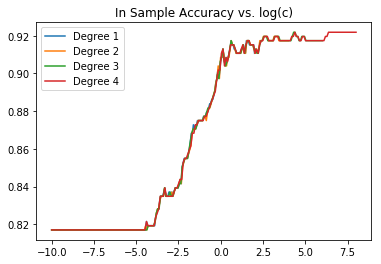

In [387]:
for i in range(len(results)):
    plt.plot(results[i][0], results[i][1], label = "Degree "+str(i+1))
plt.legend()
plt.title("In Sample Accuracy vs. log(c)");

### c. Choose the optimal degree and the optimal regularization constant C based on these graphs.  Use the optimal degree and C to compute and report the final out-of-sample accuracy of the best classification model selected. 

In [388]:
# Print the Optimal Performance and Corresponding Parameters; Code in part b)
print("--- Optimal Parameters ---")
print("The best accuracy: {}".format(max_accuracy))
print("The optimal degree at this accuracy: {}".format(max_degree))
print("The optimal constant C: {}".format(max_C))

# Comput Out of Sample Accuracy with Optimal Parameters

clf = svm.SVC(kernel='rbf', degree = max_degree, C = max_C)
clf.fit(X_train_1, Y_train_1)
pred = clf.predict(X_vali)

print("--- OOS Accuracy ---") 
print(accuracy_score(Y_vali, pred))

--- Optimal Parameters ---
The best accuracy: 0.921875
The optimal degree at this accuracy: 3
The optimal constant C: 74.5565418805813
--- OOS Accuracy ---
0.914414414414


## Task 3 (5+5=10pts).

### This task is to be done by hand rather than using Python.

Assume you have a data set as below. It contains records of cars with three features: the type of the car (sports or SUV), the color of the car (red or yellow), and the origin of the car (domestic or imported). And the labels for the data are yes (car was stolen) and no (car was not stolen).

CarType,Color,Origin,Stolen?

sports,red,domestic,yes

sports,red,domestic,yes

sports,red,domestic,yes

sports,red,imported,yes

SUV,yellow,imported,yes

SUV,red,imported,yes

---

SUV,red,domestic,no

SUV,yellow,imported,no

SUV,yellow,domestic,no

sports,yellow,imported,no




### a) Calculate the following sample probabilities:

P(Yes) = 6 / 10 = 0.6

P(No) = 4 / 10 = 0.4

P(Red|Yes) = 5 / 6 = 0.83

P(SUV|Yes) = 2 / 6 = 0.33

P(Domestic|Yes) = 3 / 6 = 0.5

P(Red|No) = 1 / 4 = 0.25

P(SUV|No) = 3 / 4 = 0.75

P(Domestic|No) = 2 / 4 = 0.5

### b) Using naive Bayes classification, what is the probability that a red, domestic SUV will be stolen?

(5/6 x 2/6 x 1/2 x 6/10) / [6/10 x (5/6 + 2/6 + 1/2)] = 0.083

In [389]:
# Validation

nom = 6/10*(5/6 * 2/6 * 1/2)
denom = 6/10*(5/6 + 2/6 + 1/2)
nom/denom

0.08333333333333333

## Task 4 (4+2+2+2=10pts)

Consider the following problem involving Gaussian Naive Bayes classification.  We use eight factors to predict if people have diabetes or not. The variables are:

y: The label (0 - no diabetes, 1 - diabetes)

t_pre: Number of times pregnant

glu: Plasma glucose concentration a 2 hours in an oral glucose tolerance test

blood_p: Diastolic blood pressure (mm Hg)

triceps: Triceps skin fold thickness (mm)

serum: 2-Hour serum insulin (mu U/ml)

b_m: Body mass index (weight in kg/(height in m)^2)

pedigree_f: Diabetes pedigree function

age: Age (years)

### Using the data provided below, learn a Naive Bayes classifier from the training data and answer the following questions: 

In [390]:
# Training data
data_train=pd.read_csv("HW2_task4_train.csv") 
y_train=data_train.iloc[:,1] 
X_train=data_train.iloc[:,2:] 

# Testing data
data_test=pd.read_csv("HW2_task4_test.csv")
y_test=data_test.iloc[:,1]
X_test=data_test.iloc[:,2:]

print(X_train.head())

   t_pre    glu  blood_p  triceps  serum   b_m  pedigree_f   age
0    3.0  158.0     64.0     13.0  387.0  31.2       0.295  24.0
1    0.0   84.0     64.0     22.0   66.0  35.8       0.545  21.0
2    9.0  120.0     72.0     22.0   56.0  20.8       0.733  48.0
3    4.0  110.0     76.0     20.0  100.0  28.4       0.118  27.0
4    2.0  100.0     66.0     20.0   90.0  32.9       0.867  28.0


In [391]:
len(X_train)

236

### a) What is the prediction accuracy for Naive Bayes, both in sample (on the training data) and out of sample (on the test data)?

In [392]:
# Train a Naive Bayes Classifier and measure accuracies

from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
y_pred = clf.fit(X_train, y_train).predict(X_train)
print("In Sample Accuracy: {}".format(accuracy_score(y_train, y_pred)))

y_pred = clf.fit(X_train, y_train).predict(X_test)
print("Out of Sample Accuracy: {}".format(accuracy_score(y_test, y_pred)))

In Sample Accuracy: 0.7584745762711864
Out of Sample Accuracy: 0.7911392405063291


### b) What is the prior probability of diabetes, learned from the training data?

In [393]:
np.count_nonzero(y_train == 1.0) / len(y_train)

0.3008474576271186

### c) What is the mean and variance of each input variable for patients with diabetes?

In [394]:
def CalMeanVar(df):
    '''
    This function calculates mean and variance of all features (excluding target and 
    dummy columns)
    Input: data frame
    Output: None
    
    '''
    
    for i in range(2, len(df.columns)):
        print("{} | mean: {} | var: {}".format(df.columns[i], 
                                               df.iloc[:, i].mean(), 
                                               df.iloc[:, i].var()))
    return

CalMeanVar(data_train[data_train.y == 1.0])

t_pre | mean: 4.070422535211268 | var: 12.380684104627761
glu | mean: 144.14084507042253 | var: 937.9798792756535
blood_p | mean: 74.56338028169014 | var: 190.42092555331996
triceps | mean: 33.478873239436616 | var: 95.31026156941651
serum | mean: 209.2112676056338 | var: 16108.94044265593
b_m | mean: 35.22394366197182 | var: 39.168704225352116
pedigree_f | mean: 0.6390422535211271 | var: 0.19275789818913477
age | mean: 35.7887323943662 | var: 105.3404426559356


### d) What is the mean and variance of each input variable for patients without diabetes?

In [395]:
CalMeanVar(data_train[data_train.y == 0.0])

t_pre | mean: 2.690909090909091 | var: 6.812416851441231
glu | mean: 111.46666666666667 | var: 609.6894308943092
blood_p | mean: 69.2060606060606 | var: 137.20118255728022
triceps | mean: 27.2 | var: 108.92926829268296
serum | mean: 127.0060606060606 | var: 8369.713377679238
b_m | mean: 31.709090909090893 | var: 40.165343680709526
pedigree_f | mean: 0.46868484848484815 | var: 0.08511825373244639
age | mean: 28.393939393939394 | var: 72.88654841093859


## Task 5 (10+15=25 pts)

We have an artificial data set split, where the training set contains both labeled and unlabeled data. Column 'y' is the label, and columns '0','1','2' are categorical variables.

In [396]:
data_train=pd.read_csv("HW2_task5_train.csv")
y_Labeled_train=data_train.iloc[:,1] 
X_Labeled_train=data_train.iloc[:,2:] 

data_test=pd.read_csv("HW2_task5_test.csv")
y_Labeled_test=data_test.iloc[:,1]
X_Labeled_test=data_test.iloc[:,2:]

data_Unlabeled=pd.read_csv("HW2_task5_unlabeled.csv")
X_Unlabeled_train=data_Unlabeled.iloc[:,1:]

### a) Learn a discrete Naive Bayes classifier from  X_Labeled_train, use it to predict the labels of X_Labeled_test, and report the classification accuracy.

In [397]:
# Train a Gaussian Naive Bayes Model

clf = GaussianNB()

y_pred = clf.fit(X_Labeled_train, y_Labeled_train).predict(X_Labeled_test)
print("Out of Sample Accuracy: {}".format(accuracy_score(y_Labeled_test, y_pred)))

Out of Sample Accuracy: 0.9722222222222222


In [468]:
# Run CV for benchmarking 
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_Labeled_train, y_Labeled_train, cv=3, 
                         scoring = 'accuracy')

print("Mean Accuracy from CV: {}".format(scores.mean()))

Mean Accuracy from CV: 0.8333333333333334


### b) Improve the classification by using the unlabeled data, data_Unlabeled, and the EM semi-supervised algorithm to predict the labels of X_Labeled_test, and report the new accuracy.

In [481]:
class PseudoLabeler():
    
    '''
    This is a class object of a Semi-Supervised Learning solution with 
    the following methods:
    
    1) fit: this method fits a model based on mixed dataset (labeled + unlabeld data) by 
         using the specified modeling technique (e.g. GaussianNB, XGB, RandomForest)
    2) create_augmented_train: this method creates an augmented dataset by labeling 
                               the unlabeled data, sampling it, and mixing it the labeled data
    3) predict: this method predicts using the validation dataset
    4) aug_CV: this method performs a cross validation using augmented dataset
    
    '''
    
    def __init__(self, model, unlabeled_data, labeled_X, labeled_y,
                sample_rate, seed = 123):
        
        '''
        This initializes the class with a modelling technique, unlabeled dataset, 
        labeled features, labeled target, and sampling rate (% of unlaebled data to use)
        '''
        
        
        from sklearn.utils import shuffle
        from sklearn.model_selection import cross_val_score
        
        self.sample_rate = sample_rate
        self.seed = seed
        self.model = model
        self.model.seed = seed
        self.unlabeled_data = pd.DataFrame(unlabeled_data)
        self.labeled_X = pd.DataFrame(labeled_X)
        self.labeled_y = pd.DataFrame(labeled_y)
        self.cv_scores = []
        
    def fit(self, X, y):
        '''
        Fit the data using pseudo labeling
        '''
        augmented_y, augmented_X = self.create_augmented_train()
        self.cv_scores = self.aug_CV(augmented_X, augmented_y)
                
        self.model.fit(augmented_X, 
                       augmented_y)
        return self
        
    def create_augmented_train(self):
        
        '''
        Create and return augmented train and test sets that consist of 
        pseudo-labeled and labeled data
        '''
        
        num_of_samples = int(len(self.unlabeled_data)*self.sample_rate)
        
        # Train a model and create pseudo labels
        self.model.fit(self.labeled_X, self.labeled_y)
        pseudo_labels = pd.DataFrame(self.model.predict(self.unlabeled_data), 
                                     columns = ['y'])
        
        # Add pseudo labels to the test data
        pseudo_data = pd.concat([pseudo_labels, self.unlabeled_data], axis = 1)
        
        # Take a subset of the pseudo test set based on sample rate
        sampled_pseudo_data = pseudo_data.sample(n = num_of_samples, 
                                                 random_state = self.seed)
        temp_train = pd.concat([self.labeled_y, self.labeled_X], axis = 1)
        
        # Mix and shuffle the labeled and unlabeled data
        augmented_train = pd.concat([sampled_pseudo_data, temp_train])
        augmented_train = shuffle(augmented_train, random_state = self.seed)
        
        print("Sample Size: {}".format(augmented_train.shape[0]))
        
        augmented_y = augmented_train.iloc[:, 0]
        augmented_X = augmented_train.iloc[:, 1:]
                
        return augmented_y, augmented_X
    
    def predict(self, X):

        return self.model.predict(X)
    
    def aug_CV(self, augmented_X, augmented_y):
        from sklearn.model_selection import KFold
        kf = KFold(n_splits=3, random_state= 123)
        scores = cross_val_score(self.model, augmented_X, augmented_y, cv=kf, 
                                 scoring = 'accuracy')
        
        print("Mean Accuracy in CV: {}".format(scores.mean()))
        
        return scores
    
    
# Code Reference: https://www.analyticsvidhya.com/blog/2017/09/
# pseudo-labelling-semi-supervised-learning-technique/
# The code was modified and re-purposed for the purpose of this exercise

In [487]:
test = pd.DataFrame(y_Labeled_train)
test2 = pd.DataFrame(X_Labeled_train)
test3 = pd.concat([y_Labeled_train, X_Labeled_train])

In [493]:
# Analyze performance given a range of sample rate
# Sample Rate = % of sampling portion from the unlabeled dataset

for rate in np.linspace(0.1, 0.8, 5):
    
    EM = PseudoLabeler(GaussianNB(),
                        X_Unlabeled_train,
                        X_Labeled_train,
                        y_Labeled_train,
                        sample_rate=rate)
    
    EM.fit(X_Labeled_train, y_Labeled_train)
    em_pred = EM.predict(X_Labeled_test)
    score = accuracy_score(y_Labeled_test, em_pred)
    print("Unlabeled Data Sample rate: {} | Out of Sample Accuracy: {}".format(rate, score))
    print("---")

Sample Size: 19
Mean Accuracy in CV: 0.9523809523809524
Unlabeled Data Sample rate: 0.1 | Out of Sample Accuracy: 1.0
---
Sample Size: 37
Mean Accuracy in CV: 0.9465811965811967
Unlabeled Data Sample rate: 0.275 | Out of Sample Accuracy: 0.9722222222222222
---
Sample Size: 56
Mean Accuracy in CV: 0.94541910331384
Unlabeled Data Sample rate: 0.45000000000000007 | Out of Sample Accuracy: 0.9722222222222222
---
Sample Size: 74
Mean Accuracy in CV: 0.9461111111111111
Unlabeled Data Sample rate: 0.625 | Out of Sample Accuracy: 0.9722222222222222
---
Sample Size: 93
Mean Accuracy in CV: 0.967741935483871
Unlabeled Data Sample rate: 0.8 | Out of Sample Accuracy: 0.9722222222222222
---


### Note

Due to the limited amount of training and validation (both labeled and unlabeld), I think it's important to analyze both CV and Out of Sample accuracy. By analyzing the results, it demonstrated the benefits of semi-supervised learning because:

1) The out of sample accuracy from all sampling rate are equal or greater than 0.9722. However, one of the case provided 100% accuracy. This might due to overfitting.

2) Simple NBC achieved an average CV accuracy of 0.83. Semi-Supervised Learning provided greater average CV accuracy, which ranges from 0.95 - 0.97.